In [1]:
import string
import numpy as np
import tensorflow as tf
from tensorflow.keras import initializers
from keras.models import Model
from tensorflow.keras.utils import Sequence
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import scipy.sparse
from sklearn.model_selection import train_test_split
import tensorflow.keras.callbacks as callbacks
import matplotlib.pyplot as plt

In [2]:
books = [1, 2, 3, 4]
window_size = 2
SEED = 42
batch_size = 128
embedding_size = 25
epoch_num = 30

In [4]:
book_text = ""

for book in books:
  with open (f"harry_potter/HP{book}.txt", 'r') as f:
      data = str(f.read()).lower()
      book_text += data + ' '
      f.close()

formatted = re.compile(r'[A-Za-z]+[\w^\']*|[\w^\']*[A-Za-z]+[\w^\']*')
formatted = formatted.findall(book_text.lower())
book_text = None

In [5]:
unique_words = np.unique(formatted)
dict_size = len(unique_words)
corpus_size = len(formatted)
print(f"Vocab size : {dict_size}\nTotal length of corpus : {corpus_size}")

Vocab size : 14262
Total length of corpus : 482093


In [6]:
encoding_to_word = {}
word_to_encoding = {}

for i, word in enumerate(unique_words):
    encoding_to_word[i] = word
    word_to_encoding[word] = i

In [7]:
window = [i for i in range(-window_size, window_size + 1) if i != 0]
data = []
labels = []

for i in range(corpus_size):
    for j in window:
        if i + j >= 0 and i + j < corpus_size:
            data.append(word_to_encoding[formatted[i]])
            labels.append(word_to_encoding[formatted[i + j]])

data = np.array(data)
labels = np.array(labels)

In [8]:
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

In [9]:
tf.random.set_seed(SEED)
data = tf.keras.utils.to_categorical(data, num_classes=dict_size, dtype=int)
labels = tf.keras.utils.to_categorical(labels, num_classes=dict_size, dtype=int)
train_gen = DataGenerator(data, labels, batch_size)

MemoryError: Unable to allocate 102. GiB for an array with shape (1928366, 14262) and data type int32

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=embedding_size,
                          activation='linear',
                          input_shape=(dict_size,),
                          name='hidden_1'),
    tf.keras.layers.Dense(units=dict_size,
                          activation='softmax',
                          name='output')
])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_1 (Dense)            (None, 25)                356575    
                                                                 
 output (Dense)              (None, 14262)             370812    
                                                                 
Total params: 727,387
Trainable params: 727,387
Non-trainable params: 0
_________________________________________________________________


In [11]:
optimizer = tf.keras.optimizers.Adam()
loss_function = tf.keras.losses.CategoricalCrossentropy()
model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

In [12]:
hisotry = model.fit(train_gen, epochs = epoch_num, shuffle = True, callbacks=[
        callbacks.ReduceLROnPlateau(monitor='loss', patience=5),
        callbacks.EarlyStopping(monitor='loss', patience=5),
        callbacks.CSVLogger("model_data.csv", separator=",", append=True)
        ])

Epoch 1/30
15066/15066 [==============================] - 207s 13ms/step - loss: 6.6925 - accuracy: 0.0550 - lr: 0.0010
Epoch 2/30
15066/15066 [==============================] - 206s 14ms/step - loss: 6.4392 - accuracy: 0.0718 - lr: 0.0010
Epoch 3/30
15066/15066 [==============================] - 205s 14ms/step - loss: 6.3661 - accuracy: 0.0765 - lr: 0.0010
Epoch 4/30
 9047/15066 [=================>............] - ETA: 1:22 - loss: 6.3202 - accuracy: 0.0784

KeyboardInterrupt: ignored

In [ ]:
model.save("nlp_model_new.tf", save_format='tf')

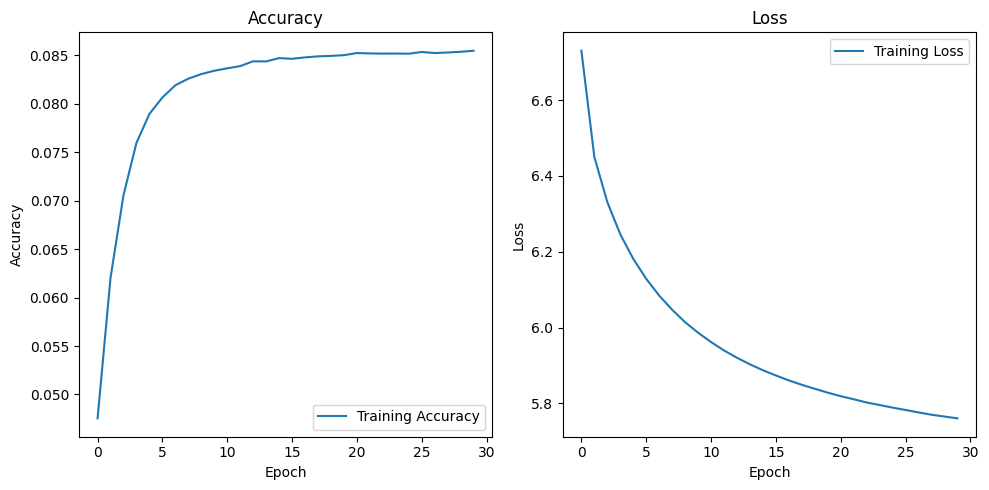

In [ ]:
# Plotting accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(hisotry.history['accuracy'], label='Training Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(hisotry.history['loss'], label='Training Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
embed_model = Model(inputs=model.input, outputs=model.layers[0].output)

In [ ]:
def get_embedding(model, input_word):

    word_ind = word_to_encoding[input_word]
    word_enc = tf.keras.utils.to_categorical(word_ind, num_classes=dict_size, dtype=int)

    word_enc = word_enc.reshape(1, -1)

    return np.array(model(word_enc)[0])

In [ ]:
#Harry -> wand, wizard, potter etc
from numpy.linalg import norm
def get_similar_words(model, input_word):
  #Get the 5 most similar wrods to input word
  input_embedding = get_embedding(model, input_word)

  embedding_dict = {}

  for word in unique_words:
    word_embedding = get_embedding(model, word)
    dist = np.linalg.norm(input_embedding - word_embedding)
    embedding_dict[word] = dist

  return embedding_dict

In [ ]:
word_dict = get_similar_words(embed_model, "hermione")
list1 = sorted(word_dict, key=word_dict.get, reverse = False)
list2 = sorted(word_dict, key=word_dict.get, reverse = True)

In [ ]:
for word in list1[:100]:
  print(word, word_dict[word])

# for word in word_book[:20]:
#   print(f'{word} : ' + str(word_dict[word]))

hermione 0.0
mmm 2.7380803
mortis 2.7925336
ron 2.794163
undaunted 2.8362098
daddy 2.867758
desert 2.8760962
admirable 2.884234
headmistress 2.8858354
laundry 2.8864841
fascinated 2.8977437
pimply 2.9049067
daubed 2.9327705
pebbles 2.9332204
giggled 2.9394798
snape 2.9521203
forcing 2.9725704
regular 2.9844317
it 2.9867413
him 2.9869626
ghoulie 2.9945245
jaw 2.997785
yelped 3.0020094
sponge 3.003011
hagrid 3.004888
redder 3.0090094
freezing 3.012966
wonderingly 3.0343678
dip 3.0434284
blocking 3.0520856
automatically 3.0525634
begins 3.0541854
sahara 3.0556865
challenged 3.0566342
grand 3.0602336
brocklehurst 3.0616624
fluxweed 3.067384
stifled 3.0743358
sentiments 3.0784664
north 3.0806108
mandy 3.0864093
mops 3.089467
maroon 3.092262
detergent 3.0937214
myths 3.094435
pointlessly 3.0987
clench 3.1013217
alike 3.1038895
boaters 3.1060472
loss 3.1087453
wailing 3.1103964
theory 3.1137452
prodded 3.1158855
thankfully 3.1217933
scorch 3.122039
awfully 3.1232255
yorkshire 3.1260605
creep 

In [ ]:
word_dict['harry']

0.3456408